In [1]:
import matplotlib.pyplot as plt
import numpy as np

from dolphin import HalfWindow, Strides
from dolphin.phase_link import _core, simulate

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Set up a simulate stack of deformation with correlated noise

In [2]:
num_time, *shape2d = 30, 128, 128
num_pixels = np.prod(shape2d)

C, _ = simulate.simulate_coh(num_time)
defo_stack = simulate.make_defo_stack((num_time, *shape2d), sigma=20, max_amplitude=10)
defo_phase = np.exp(1j * defo_stack)

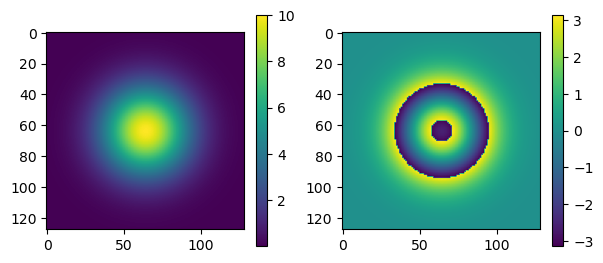

In [3]:
fig, axes = plt.subplots(ncols=2, figsize=(7, 3))
axim = axes[0].imshow(defo_stack[-1])
fig.colorbar(axim, ax=axes[0])

axim = axes[1].imshow(np.angle(defo_phase[-1]))
fig.colorbar(axim, ax=axes[1])

In [5]:
samps3d = simulate.make_noisy_samples(C, defo_stack)

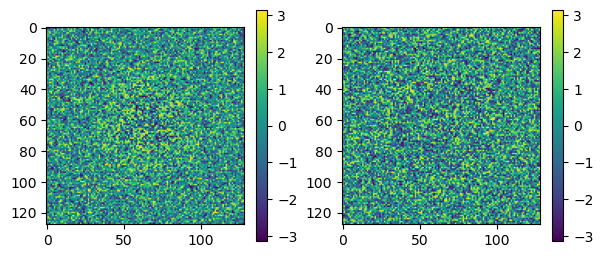

In [6]:
fig, axes = plt.subplots(ncols=2, figsize=(7, 3))

img1 = np.angle(samps3d[0].conj() * samps3d[10])
img2 = np.angle(samps3d[0].conj() * samps3d[-1])

for ax, img in zip(axes, [img1, img2]):
    axim = ax.imshow(img)
    fig.colorbar(axim, ax=ax)

## Run phase linking on the simulated stack to recover the deformation

In [7]:
strides = Strides(1, 1)
half_window = HalfWindow(5, 5)

### Run the EMI algorithm

CPU times: user 7.6 s, sys: 565 ms, total: 8.17 s
Wall time: 6.33 s


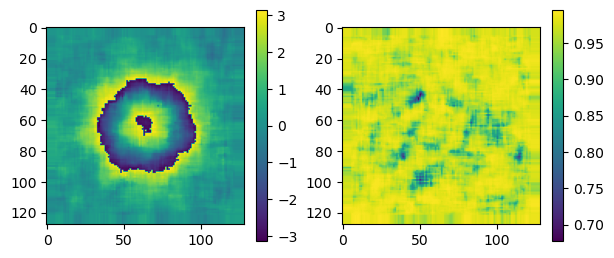

In [8]:
%%time
pl_out_emi = _core.run_phase_linking(samps3d, half_window=half_window, strides=strides)

fig, axes = plt.subplots(ncols=2, figsize=(7, 3))


for ax, img in zip(axes, [np.angle(pl_out_emi.cpx_phase[-1]), pl_out_emi.temp_coh]):
    axim = ax.imshow(img)
    fig.colorbar(axim, ax=ax)

### Run the EVD algorithm

CPU times: user 1.49 s, sys: 266 ms, total: 1.76 s
Wall time: 1.31 s


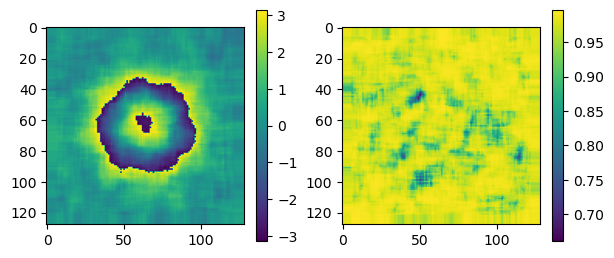

In [9]:
%%time
pl_out_evd = _core.run_phase_linking(
    samps3d, half_window=half_window, strides=strides, use_evd=True
)

fig, axes = plt.subplots(ncols=2, figsize=(7, 3))

for ax, img in zip(axes, [np.angle(pl_out_evd.cpx_phase[-1]), pl_out_evd.temp_coh]):
    axim = ax.imshow(img)
    fig.colorbar(axim, ax=ax)

## Check the RMSE of the stacks

In [10]:
np.angle(defo_phase * pl_out_evd.cpx_phase).sum(axis=(1, 2))

array([-4.3025661e-06,  1.5954834e+03,  3.2521582e+03,  4.8683193e+03,
        6.6705547e+03,  7.1757417e+03,  5.4422593e+03,  5.2914023e+03,
        5.3864727e+03,  4.9943848e+03,  5.1033467e+03,  5.2114697e+03,
        5.3217363e+03,  5.8540405e+03,  6.0535098e+03,  5.7950146e+03,
        5.2872959e+03,  4.8189971e+03,  4.8390674e+03,  5.0720879e+03,
        5.1591855e+03,  5.4020986e+03,  5.6514023e+03,  5.7674033e+03,
        5.5892793e+03,  5.4287778e+03,  5.4271631e+03,  5.3089902e+03,
        5.2860093e+03,  5.3068896e+03], dtype=float32)

In [11]:
np.angle(defo_phase * pl_out_emi.cpx_phase).sum(axis=(1, 2))

array([-3.3474209e-06,  1.7309321e+03,  3.4283479e+03,  5.0706733e+03,
        6.8206797e+03,  7.1798916e+03,  5.8099360e+03,  5.4770039e+03,
        5.4111328e+03,  5.0952212e+03,  5.1653008e+03,  5.2369697e+03,
        5.4434082e+03,  5.9216982e+03,  6.2763369e+03,  5.9560020e+03,
        5.4299385e+03,  5.0155713e+03,  4.9247598e+03,  5.1023760e+03,
        5.3347559e+03,  5.6040928e+03,  5.8530649e+03,  6.0653682e+03,
        5.8327480e+03,  5.6139536e+03,  5.5874033e+03,  5.4674424e+03,
        5.3649487e+03,  5.3252979e+03], dtype=float32)

In [12]:
simulate.rmse(defo_phase, pl_out_evd.cpx_phase)

0.23635265

In [13]:
simulate.rmse(defo_phase, pl_out_emi.cpx_phase)

0.21739595